In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

# Imports

In [3]:
# Make modules available
import sys
sys.path.insert(1, "./modules")

# General imports
import os
import cv2
import torch
import numpy as np
import torchvision
from scipy import ndimage
from importlib import reload
from torch.utils.data import DataLoader, random_split

# Import modules
from model import *
from dataset import *
from helpers import *

# Make randomicity reproduceable
torch.manual_seed(24)

# Load Dataset

In [4]:
batch_size = 1

In [5]:
# Choose device
device = "cuda:0" if torch.cuda.is_available() else "cpu"
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cuda


In [6]:
# Convert XML files to CSV to create dataset
xml_to_csv('./Dataset/blob/**/*.xml', 'labels.csv')

Processed:  8857  images


In [7]:
# Create custom dataset class
dataset_dt = DetectionDataset('labels.csv')

In [8]:
# Split dataset
train_size = int(0.8 * len(dataset_dt))
test_size = int(0.1 * len(dataset_dt))
validation_size = len(dataset_dt) - (train_size + test_size)

train_dt, validation_dt, test_dt = random_split(dataset_dt, [train_size, validation_size, test_size])

In [9]:
print("Size of detection test set", len(test_dt))
print("Size of detection training set:", len(train_dt))
print("Size of detection validation set:", len(validation_dt))

Size of detection test set 885
Size of detection training set: 7086
Size of detection validation set: 887


In [10]:
test_loader_dt = DataLoader(test_dt, batch_size=batch_size, shuffle=True)
train_loader_dt = DataLoader(train_dt, batch_size=batch_size, shuffle=True)
validation_loader_dt = DataLoader(validation_dt, batch_size=batch_size, shuffle=True)

Shape:  torch.Size([1, 3, 480, 640])
Shape:  torch.Size([1, 3, 480, 640])


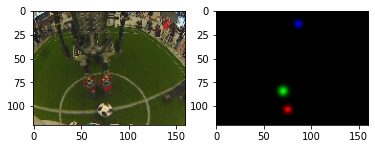

In [11]:
# Display first training image
for images, targets in train_loader_dt:
    print("Shape: ", images.shape)
    print("Shape: ", targets.shape)
    
    show_image_and_probmap(downsample(images)[0], downsample(targets)[0])
    
    """
    print(np.where(downsampled_target[0][0] == downsampled_target[0][0].max()))
    print("Ball: ", downsampled_target[0][0].max())
    print(np.where(downsampled_target[0][1] == downsampled_target[0][1].max()))
    print("Robot: ", downsampled_target[0][1].max())
    print(np.where(downsampled_target[0][2] == downsampled_target[0][2].max()))
    print("Goalpost: ", downsampled_target[0][2].max())
    print("\n")
    """
    break

# Load Trained Model

In [12]:
# Model
model = Model(device,640,480)
model = to_device(model, device)

In [13]:
model.eval()
print("Model ready for evaluation...")

Model ready for evaluation...


In [14]:
model.load_state_dict(torch.load("/home/user/taouil/NimbRoNet2/models/model_v3_149.pt"), strict=False)

<All keys matched successfully>

# Visual Inspection

In [15]:
#dataset_dt.set_resolution(480,640)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


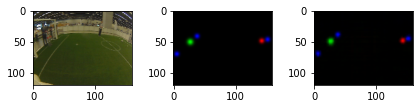

In [16]:
for image, target in test_loader_dt:    
    output = model(to_device(image,device), head="detection")    
    #show_image_and_probmap(image[0], downsample(target)[0])
    show_image_and_probmap2(downsample(image)[0], downsample(target)[0], output.cpu()[0].detach())
    break

# Metric Evaluation

In [17]:
detection_metric(model, test_loader_dt)

The loader has a length of 885
[821, 795, 996]
[0, 38, 27]
[36, 103, 91]
[103, 271, 175]
Ball    	Recall:0.958
		Precision:1.000
		Accuracy: 0.963
		F1 Score:0.979
		FDR:0.000
Robot    	Recall:0.885
		Precision:0.954
		Accuracy: 0.883
		F1 Score:0.919
		FDR:0.046
Goal Post    	Recall:0.916
		Precision:0.974
		Accuracy: 0.908
		F1 Score:0.944
		FDR:0.026


(0.9470553038177326,
 0.9180458697208272,
 0.91985900521688,
 0.9759962636080824,
 0.02400373639191748)